# **Pràctica 2 - L'enfonsament del Titànic i les possiblitats de sobreviure**
## Inteligència Artificial - Machine Learning
### Grau en Enginyeria Informàtica - Universitat de les Illes Balears

#### Autors: Lluis Barca Pons i Victor Canelo Galera

Desde l'assignatura d'Intelgència Artificial se'ns ha demanat realitzar un anàlisis sobre el famós enfonsament del vaixell Titànic, l'any 1912. Durant aques naufragi, van morir 1502 de 2224 persones registrades, entre passatgers i tripulants.

El més interessant és que sembla ser que existia diferents probabilitats de sobreviure entre alguns grups de persones. Per tant, l'objectiu d'aquesta pràctica és realitzar un model predictiu, utilizant les dades reals recollides, que ens mostri quins tipus de persones tenien més probabiitats de viure.

Llavors, la practica es dividira en dues parts:

1. Entrenar una serie de predictors i comparar el seu rendiment.

2. Obtenir i analitzar la importancia de cada caracteristica per cada un dels models generats.

# 1. Primera part

Per a la configuració del nostre entorn, necessitarem els corresponents imports de les diferents llibreries de Python que utilitzarem durant tota la pràctica.

In [170]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier 

## 1.1. Neteja del dataset

In [171]:
df = pd.read_csv("dades.csv")
df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


En primer lloc, comprovarem si tenim alguna columna del nostre dataset amb algun valor NaN (no numèric):

In [172]:
df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

Ens adonam que tres de les dotze variables tenen valors no numèrics. Però, ens interessa saber quin tant per cent de les files no ens donen cap informació, ja que podria ser una informació d'útilitat per descartar directament qualque variable.

In [173]:
na_ratio = ((df.isnull().sum() / len(df))*100).sort_values(ascending = False)
print(na_ratio)

Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64


Analitzam els valors no numèrics de les tres primeres variables:

- **Cabin**: Els valors no numèrics ens indiquen realment que aquell passatger no tenia cabina (camarot). Llavors, realment un 77% dels passatgers anaven sense cabina. Això ens indica que no és necessari eliiminar aquesta variable (de primeres), ja que ens podria estar donant una informació útil; que valorarem en fer la correlació. El que farem serà modificar la taula i els passatgers amb valor no numèric passaran a tenir un 0 i els que tinguin qualque cabina 1. D'aquesta manera sabrem quin passatger té o no cabina.
- **Age**: L'edat sol ser una informació de gran valor, ja que ens podria donar molta informació de quin grup de persones tenen més probabilitats de sobreviure. Per tant, haurem de substituir els valors no numèrics per la mitjana d'edat de la resta de persones al vaixell; amb l'objectiu de minimitzar l'impacte que podrien tenir en els nostres resultats aquesta falta d'informació d'alguns tripulants.
- **Embarked**: Aquesta variable ens aporta poca infromació útil, degut a que no hi ha una relació directe entre les persones que embarquen en *x* port, amb la probabilitat de sobreviure. El vaixell es va enfonsar en mig de l'Atlàntic, i a causa d'un iceberg. Però, no la descartarem fins a realitzar la respectiva correlacio, i com el nombre de valors no numèrics és insignficiant, tampoc la netejarem. El que si farem (per realitzar la respectiva correlació) és modificar els valors per S = 1, C = 2, Q = 3, per diferenciar els tres ports d'orígen.

A continuació, el procés de neteja del dataset:

In [174]:
model = df

# Eliminam les variables Name i Ticket
del model["Name"]
del model["Ticket"]

# Modificam la variable Sex
model = model.replace(to_replace="male", value=0)
model = model.replace(to_replace="female", value=1)

# Calculam la mitjana d'edat de la gent del vaixell
edat = model[["Age"]]
edat = edat.dropna()
edat = int(edat.mean())
edat = float(edat)

# Modificam els valors no numèrics per la mitjana
model["Age"] = model["Age"].replace(np.nan, edat)

# Modificam el valor Cabin
model["Cabin"] = model["Cabin"].notnull().astype("int")

# Modificam el valor Embarked
model["Embarked"] = model["Embarked"].replace(to_replace="S", value=1)
model["Embarked"] = model["Embarked"].replace(to_replace="C", value=2)
model["Embarked"] = model["Embarked"].replace(to_replace="Q", value=3)

model


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0,1.0
1,2,1,1,1,38.0,1,0,71.2833,1,2.0
2,3,1,3,1,26.0,0,0,7.9250,0,1.0
3,4,1,1,1,35.0,1,0,53.1000,1,1.0
4,5,0,3,0,35.0,0,0,8.0500,0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,0,1.0
887,888,1,1,1,19.0,0,0,30.0000,1,1.0
888,889,0,3,1,29.0,1,2,23.4500,0,1.0
889,890,1,1,0,26.0,0,0,30.0000,1,2.0


## 1.2. Anàlisis del dataset

En primer lloc realitzarem una correlacio de totes les variables per analitzar quines ens poden interessar i quines no.

<AxesSubplot: >

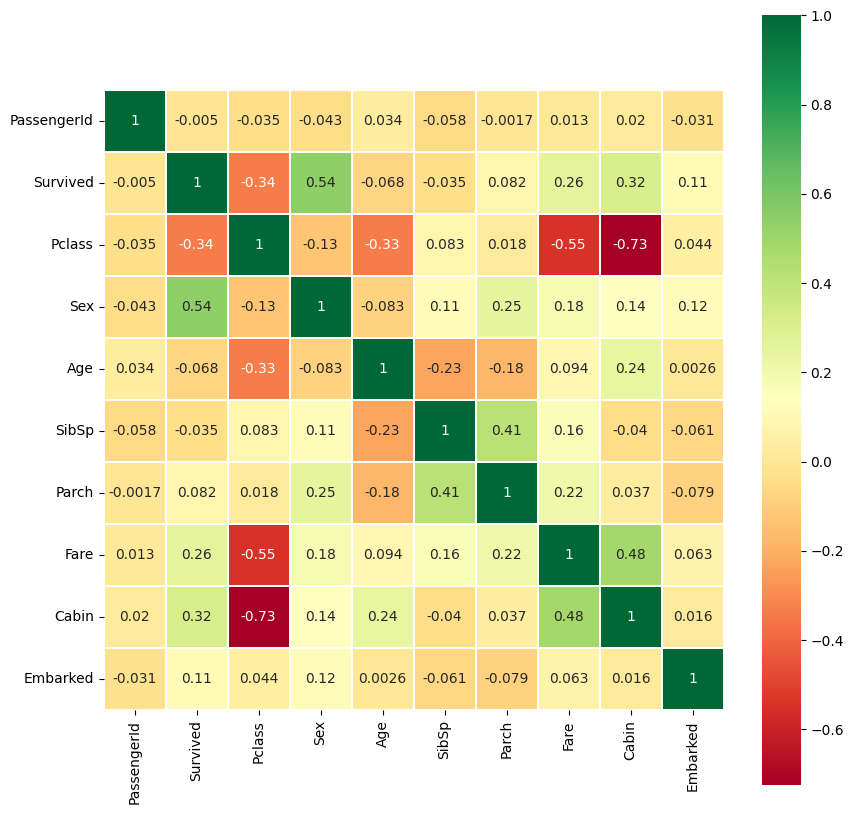

In [175]:
corr_fig = plt.figure(figsize=(10,10))
sns.heatmap(model.corr(), annot=True, square=True, cmap="RdYlGn", linewidths=0.2)

A continuació realitzarem una segona correlació amb una variable nova. Aquesta serà la variable Family, que es crearà a partir de la suma de la variable Sibsp i Parch. L'objectiu d'aquesta prova és comprobar si el fet de tenir o no familiars a bord, va ser un motiu de pes a l'hora de sobreviure. Intuitivament podriem pensar que si, però hem de comprovar-ho.

In [176]:
sibsp = model["SibSp"]
parch = model["Parch"]
family = []

# Cream la nova columna family
for i in range(len(sibsp)):
    family.append(sibsp[i] + parch[i])

# Eliminam les variables sibsp i parch del dataset
del model["SibSp"]
del model["Parch"]

# Afegim la columna family
model.insert(4, "Family", family, True)

model

,PassengerId,Survived,Pclass,Sex,Family,Age,Fare,Cabin,Embarked
0,1,0,3,0,1,22.0,7.2500,0,1.0
1,2,1,1,1,1,38.0,71.2833,1,2.0
2,3,1,3,1,0,26.0,7.9250,0,1.0
3,4,1,1,1,1,35.0,53.1000,1,1.0
4,5,0,3,0,0,35.0,8.0500,0,1.0
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,0,27.0,13.0000,0,1.0
887,888,1,1,1,0,19.0,30.0000,1,1.0
888,889,0,3,1,3,29.0,23.4500,0,1.0
889,890,1,1,0,0,26.0,30.0000,1,2.0


Tornam a fer la correlació amb la nova variable:

<AxesSubplot: >

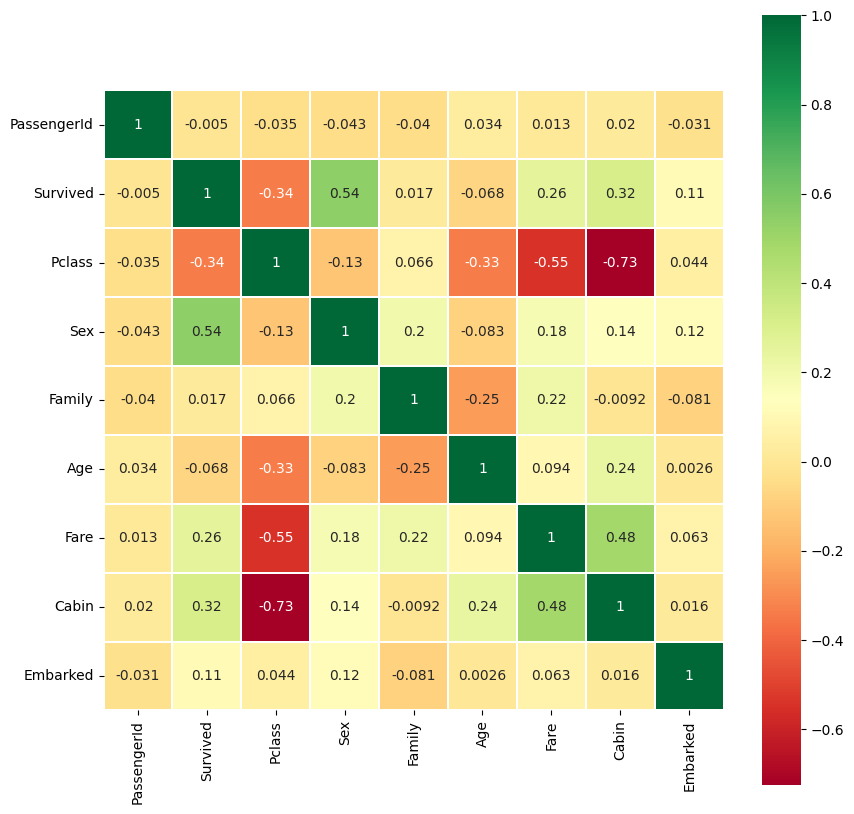

In [177]:
corr_fig = plt.figure(figsize=(10,10))
sns.heatmap(model.corr(), annot=True, square=True, cmap="RdYlGn", linewidths=0.2)

Llavors ens adonem que aquesta variable no afecta pràcticament i per tant podriem descartar-la. Llavors, les variables que més ens interessen són les que comparades amb "Survived", prenen valors o molt a prop de 1 o de -1; és a dir, que tindran molta correlació.

In [178]:
model

,PassengerId,Survived,Pclass,Sex,Family,Age,Fare,Cabin,Embarked
0,1,0,3,0,1,22.0,7.2500,0,1.0
1,2,1,1,1,1,38.0,71.2833,1,2.0
2,3,1,3,1,0,26.0,7.9250,0,1.0
3,4,1,1,1,1,35.0,53.1000,1,1.0
4,5,0,3,0,0,35.0,8.0500,0,1.0
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,0,27.0,13.0000,0,1.0
887,888,1,1,1,0,19.0,30.0000,1,1.0
888,889,0,3,1,3,29.0,23.4500,0,1.0
889,890,1,1,0,0,26.0,30.0000,1,2.0


Per tant, podem descartar també les següents variables:  

- **PassengerId (ID del passatjer):** A nivell númeric no ens aporta cap informació, únicament serveix per llistar els passatgers a una llista.
- **Family (Familiars):** Com hem observat a la correlació anterior, no és una variable debilment relacionada amb sobreviure o no.
- **Age (Edat):** Com hem observat a les correlacions anteriors, no és una variable debilment relacionada amb sobreviure o no.
- **Embarked (Port d'embarcament):** És una variable amb un índex de correlació bastant baix i per tant, descartable.

I ens quedariem amb les variables que **més correlació** tenen: [Survived, Pclass, Sex, Fare, Cabin]

In [179]:
del model["PassengerId"]
del model["Family"]
del model["Age"]
del model["Embarked"]

Una vegada feta la neteja, ens quedaria el següent dataset:

In [180]:
model

,Survived,Pclass,Sex,Fare,Cabin
0,0,3,0,7.2500,0
1,1,1,1,71.2833,1
2,1,3,1,7.9250,0
3,1,1,1,53.1000,1
4,0,3,0,8.0500,0
...,...,...,...,...,...
886,0,2,0,13.0000,0
887,1,1,1,30.0000,1
888,0,3,1,23.4500,0
889,1,1,0,30.0000,1


# 2. Entrenament

A continuació es duran a terme una serie d'entrenaments segons diferents predictors i finalment es compararan els seus rendiments. Abans però, haurem de separar el nostre conjunt de dades per a entrenament, validació i testeig. També normalitzarem les dades per a que les poguem comparar entre elles.

In [181]:
scaler = preprocessing.MinMaxScaler()

y = model["Survived"]
x = model.drop("Survived", axis=1)

# Escalam les dades en funció de x
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, stratify=y , random_state=42)

## 2.1. Regressió Logística

Hem decidit baixar el nombre de ```max_iter``` ja que el nombre d'iteracions base no és necessari. Ens dona el mateix resultat fent menys iteracions.

In [182]:
log = LogisticRegression(random_state=0, max_iter=25).fit(x_train, y_train)
y_hat = log.predict(x_test)

print(classification_report(y_test, y_hat, target_names=["Viu", "Mort"]))

              precision    recall  f1-score   support

         Viu       0.83      0.72      0.77       137
        Mort       0.63      0.77      0.69        86

    accuracy                           0.74       223
   macro avg       0.73      0.75      0.73       223
weighted avg       0.76      0.74      0.74       223



## 2.2. Perceptró

Com tenim divisions entre 0, hem decidit substituir-les per el valor 1.

In [185]:
perc = Perceptron(random_state=0).fit(x_train, y_train)
y_hat = perc.predict(x_test) 

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.85      0.64      0.73       137
           1       0.59      0.83      0.69        86

    accuracy                           0.71       223
   macro avg       0.72      0.73      0.71       223
weighted avg       0.75      0.71      0.71       223



## 2.3. Arbres de decissió

Com tenim divisions entre 0, hem decidit substituir-les per el valor 1.

In [186]:
forest = RandomForestClassifier(random_state=0).fit(x_train, y_train)

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.85      0.64      0.73       137
           1       0.59      0.83      0.69        86

    accuracy                           0.71       223
   macro avg       0.72      0.73      0.71       223
weighted avg       0.75      0.71      0.71       223



## 2.4. Comparació dels rendiments

Després de veure els resultats de cada predictor, ens adonem que el que ens dona una major precissió és el de Regressió Logistica.

# 3. Anàlisis de les característiques

# 4. Conclusions